# Tutorial: NGEM - Neural graph error mitigation

In [1]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
from pathlib import Path

from qiskit import transpile
from qiskit.circuit.random import random_circuit
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator, Estimator

from ml_qem.data.encoders.graph_utils import ExpValData
from ml_qem.data.dataio import ExpValDataWriter

In [3]:
fake_lima = FakeLimaV2()

ideal_estimator = Estimator()
noisy_esimator = BackendEstimator(fake_lima)

data_folder = "./data/ngem/"
Path(data_folder).mkdir(parents=True, exist_ok=True)

In [4]:
# generate data

N_FILES = 2
N_ENTRIES_PER_FILE = 100
N_QUBITS = 3
DEPTH = 3

operator = SparsePauliOp(["ZZZZZ", "ZIIIZ"])
writer = ExpValDataWriter()

for idx in range(N_FILES):
    print(f"Processing {idx} file...")
    
    entries = []
    for _ in range(N_ENTRIES_PER_FILE):
        
        circuit = random_circuit(N_QUBITS, DEPTH)
        transpiled_circuit = transpile(circuit, fake_lima)
        
        ideal_exp_val = ideal_estimator.run([transpiled_circuit], [operator]).result().values[0]
        noisy_exp_val = noisy_esimator.run([transpiled_circuit], [operator]).result().values[0]

        exp_val_data = ExpValData.build(
            circuit=transpiled_circuit,
            expectation_values=[
                ideal_exp_val,
                noisy_exp_val
            ],
            observable=operator,
            backend=fake_lima
        )
        entries.append(exp_val_data)
    
    save_path = os.path.join(data_folder, f"{idx}_entries.json")
    writer.save_to_file(save_path, entries)

Processing 0 file...
Processing 1 file...


In [5]:
# load data

import glob
from torch_geometric.loader import DataLoader
from ml_qem.data.loaders.dataclasses import ExpValDataSet

paths = glob.glob(f"{data_folder}/**.json")
split = int(0.6 * len(paths))
train_paths, val_paths = paths[:split], paths[split:]

BATCH_SIZE = 32

train_loader = DataLoader(ExpValDataSet(train_paths), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ExpValDataSet(val_paths), batch_size=BATCH_SIZE, shuffle=False)

for data in train_loader:
    print(data)
    break

DataBatch(x=[847, 22], edge_index=[2, 1795], edge_attr=[948, 1], y=[32, 2], circuit_depth=[32, 1], observable=[32, 2, 21], backend_nodes=[160, 3], backend_edges=[64, 8], backend_edge_features=[256, 1], batch=[847], ptr=[33])


In [6]:
# create model

from ml_qem.library.ngem import SimpleExpectationValueModel

model = SimpleExpectationValueModel(
    num_node_features=22, 
    num_obs_features=21,
    hidden_channels=10
)

In [7]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.1, 
                              patience=15, 
                              verbose=True, 
                              min_lr=0.00001)

/opt/anaconda3/envs/blackwater/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
# train
import numpy as np

min_valid_loss = np.inf


train_losses = []
val_losses = []

N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch}...")
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        ideal_exp_val, noisy_exp_val = torch.tensor_split(data.y, 2, dim=1)
        out = model(data.x, data.edge_index, noisy_exp_val, data.observable, data.circuit_depth, data.batch)
        loss = criterion(out, ideal_exp_val)     
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        ideal_exp_val, noisy_exp_val = torch.tensor_split(data.y, 2, dim=1)
        out = model(data.x, data.edge_index, noisy_exp_val, data.observable, data.circuit_depth, data.batch)
        loss = criterion(out, ideal_exp_val)        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

Epoch 0...
Epoch 1...


/opt/anaconda3/envs/blackwater/lib/python3.9/site-packages/torch_geometric/utils/sparse.py:268: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(


Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


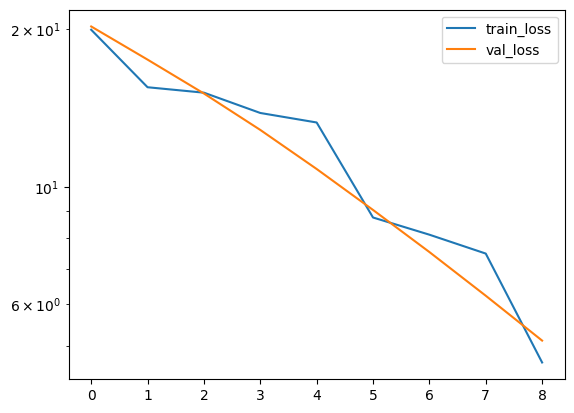

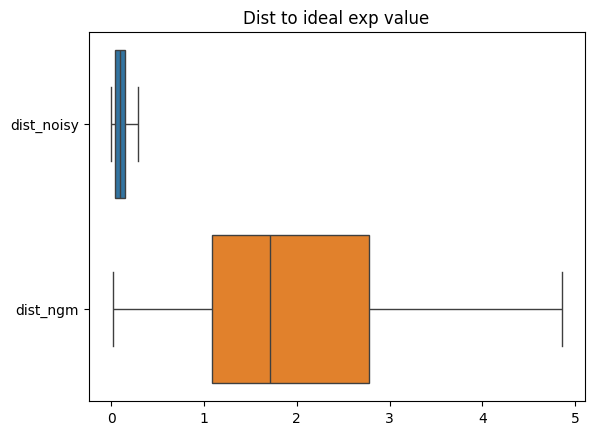

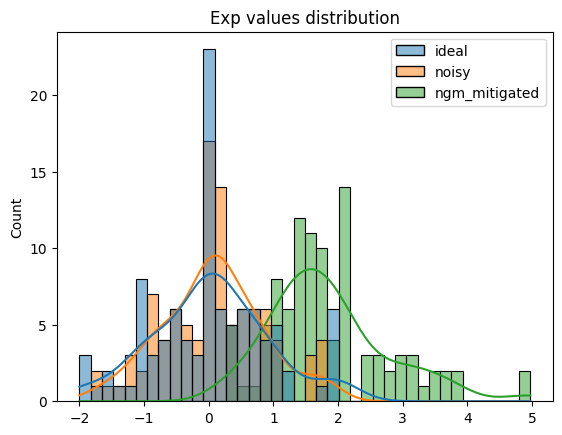

In [9]:
# visualize

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    ideal_exp_val, noisy_exp_val = torch.tensor_split(data.y, 2, dim=1)
    out = model(data.x, data.edge_index, noisy_exp_val, data.observable, data.circuit_depth, data.batch)
        
    for ideal, noisy, ngm_mitigated in zip(
        ideal_exp_val.tolist(),
        noisy_exp_val.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [11]:
# estimator

from ml_qem.primitives.learning_esimator import (
    learning_estimator,
    ScikitLearnEstimatorModel,
    TorchGeometricEstimatorModel,
)
from ml_qem.data.encoders.graph_utils import DefaultPyGEstimatorEncoder


circuit = transpile(random_circuit(5, 2),  fake_lima)
observable = SparsePauliOp(["ZZZZZ", "ZIIIZ"])

estimator = learning_estimator(
    Estimator, 
    model=TorchGeometricEstimatorModel(model, DefaultPyGEstimatorEncoder()), 
    backend=fake_lima, 
    skip_transpile=True
)()

In [12]:
estimator.run([circuit], [observable]).result()

EstimatorResult(values=array([1.59029901]), metadata=[{'original_value': 1.1102230246251565e-16}])